---
title: 2025-09-21 Weekly Notes
date: "09/21/2025"
categories:
- phd
- quarto
license: "CC BY"
copyright:
    holder: "Andrés C. Zúñiga-González"
    year: 2025
format: 
    html:
        code-fold: true
---

## Intro
This is code-focused post of how I'm building this project for more reproducibility. Also, this is the first post made entirely with a Jupyter notebook (and on an iPad using codespaces 😅), so not too sure if it will render as expected. 

So, as mentioned in last week's post, I've been working on how to use geo foundation models (GeoFMs) to classify Local CLimate Zones (LCZ). I managed to structure this project nicely using `xarray`, `dask`, and `gee`from the beginning. Currently, it is using two GeoFMs: Google's AlphaEarth and Cambridge's GeoTessera and as labels, it uses the Demuzere's global map of LCZs (2018) and the classification made with OpenStreeMaps (OSM) data created by Geoclimate (present).

## Code
### Packages and Classes import

In [1]:
%load_ext autoreload
%autoreload 2
import sys

sys.path.append('../src')

from utils.paths import guppd_path, lcz_dir
from utils.constants import lcz_dict
from gee_helpers import authenticate_ee
from city import City
from classifiers.pixel_classifier import PixelClassifier
from embeddings.geotessera import GeoTesseraEmbeddings
from embeddings.alpha_earth import AlphaEarthEmbeddings
from lcz.demuzere import Demuzere
from lcz.geoclimate import Geoclimate
import numpy as np
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors

### City boundaries setup

In [2]:
guppd_gdf = gpd.read_file(guppd_path, layer="urbanspatial_guppd_v1_polygons")
guppd_gdf.sort_values(by="GHSPOP_R23_2025", inplace=True)
# guppd_gdf = guppd_gdf[guppd_gdf["GHSPOP_R23_2025"] > 1e6]
guppd_gdf.reset_index(drop=True, inplace=True)

In [3]:
city_example_gdf = guppd_gdf[(guppd_gdf["ISO"] == "GBR") & (guppd_gdf["JRC_NAME_MAIN"] == "Cambridge")]
city_example = City(
    city=city_example_gdf["JRC_NAME_MAIN"].values[0],
    smod_id=city_example_gdf["SMOD_ID"].values[0],
    country_code=city_example_gdf["ISO"].values[0],
    bbox=city_example_gdf.total_bounds.tolist(), # minx, miny, maxx, maxy
)
city_example

City(city='Cambridge', smod_id='30_4732', country_code='GBR', bbox=[0.08131345500004272, 52.17205629800003, 0.18967890600004012, 52.249807786000076], climate_type='Cfb', utm_crs='EPSG:32631', utm_bbox=[300421.00688341603, 5784191.7236782815, 308164.895357511, 5792544.390988352])

### Embeddings Setup
Because of the nature of how LCZs were obtained, I am using AlphaEarth and GeoTessera's embeddings from 2018 and 2024, where available, to classify LCZs. THis step will either load files from `.zarr` files or extract the features from Google Earth Engine. In addition, because it is built on `dask` and `xarray` it is very easy to see the structure of the dataset (3-dimensional array). The code is capable of sorting the bounding box, resolution, and alignment of the datasets so they are compatible for pixel-level classification.

In [4]:
year = 2024
ae_2024 = AlphaEarthEmbeddings(city=city_example, year=year)
# authenticate_ee()
ae_embeddings_2024_da = ae_2024.get_embeddings()
ae_embeddings_2024_da

2025-09-19 13:42:38.365 | INFO     | embeddings.base:get_embeddings:46 - Loading cached 'AlphaEarth' embeddings from /maps/acz25/phd-thesis-data/input/Google/AlphaEarth/2024/GBR/30_4732_Cambridge_ae.zarr
2025-09-19 13:42:38.730 | INFO     | embeddings.base:get_embeddings:53 - Chunking 'AlphaEarth' embeddings


<xarray.DataArray (band: 64, y: 835, x: 774)> Size: 165MB
dask.array<rechunk-merge, shape=(64, 835, 774), dtype=float32, chunksize=(64, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 7kB 5.784e+06 5.784e+06 ... 5.793e+06 5.793e+06
  * x        (x) float64 6kB 3.004e+05 3.004e+05 ... 3.081e+05 3.082e+05
  * band     (band) object 512B 'A36' 'A04' 'A41' 'A60' ... 'A15' 'A34' 'A49'
Attributes:
    crs:      EPSG:32631

In [5]:
gt_2024 = GeoTesseraEmbeddings(city=city_example, year=year)
gt_embeddings_2024_da = gt_2024.get_embeddings()
gt_embeddings_2024_da

2025-09-19 13:42:38.809 | INFO     | embeddings.base:get_embeddings:46 - Loading cached 'GeoTessera' embeddings from /maps/acz25/phd-thesis-data/input/GEOTESSERA/clipped/2024/GBR/30_4732_Cambridge.zarr
2025-09-19 13:42:38.895 | INFO     | embeddings.base:get_embeddings:53 - Chunking 'GeoTessera' embeddings


<xarray.DataArray (band: 128, y: 836, x: 775)> Size: 332MB
dask.array<rechunk-merge, shape=(128, 836, 775), dtype=float32, chunksize=(128, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 6kB 3.004e+05 3.004e+05 ... 3.082e+05 3.082e+05
    spatial_ref  int64 8B ...
  * y            (y) float64 7kB 5.793e+06 5.793e+06 ... 5.784e+06 5.784e+06
  * band         (band) object 1kB 'A049' 'A034' 'A043' ... 'A073' 'A097' 'A103'
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [6]:
year = 2018
ae_2018 = AlphaEarthEmbeddings(city=city_example, year=year)
# authenticate_ee()
ae_embeddings_2018_da = ae_2018.get_embeddings()
ae_embeddings_2018_da

2025-09-19 13:42:38.956 | INFO     | embeddings.base:get_embeddings:46 - Loading cached 'AlphaEarth' embeddings from /maps/acz25/phd-thesis-data/input/Google/AlphaEarth/2018/GBR/30_4732_Cambridge_ae.zarr
2025-09-19 13:42:39.367 | INFO     | embeddings.base:get_embeddings:53 - Chunking 'AlphaEarth' embeddings


<xarray.DataArray (band: 64, y: 835, x: 774)> Size: 165MB
dask.array<rechunk-merge, shape=(64, 835, 774), dtype=float32, chunksize=(64, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 7kB 5.784e+06 5.784e+06 ... 5.793e+06 5.793e+06
  * x        (x) float64 6kB 3.004e+05 3.004e+05 ... 3.081e+05 3.082e+05
  * band     (band) object 512B 'A22' 'A46' 'A55' 'A04' ... 'A18' 'A12' 'A20'
Attributes:
    crs:      EPSG:32631

In [7]:
gt_2018 = GeoTesseraEmbeddings(city=city_example, year=year)
gt_embeddings_2018_da = gt_2018.get_embeddings()
gt_embeddings_2018_da

2025-09-19 13:42:39.438 | INFO     | embeddings.base:get_embeddings:46 - Loading cached 'GeoTessera' embeddings from /maps/acz25/phd-thesis-data/input/GEOTESSERA/clipped/2018/GBR/30_4732_Cambridge.zarr
2025-09-19 13:42:39.525 | INFO     | embeddings.base:get_embeddings:53 - Chunking 'GeoTessera' embeddings


<xarray.DataArray (band: 128, y: 836, x: 775)> Size: 332MB
dask.array<rechunk-merge, shape=(128, 836, 775), dtype=float32, chunksize=(128, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 6kB 3.004e+05 3.004e+05 ... 3.082e+05 3.082e+05
    spatial_ref  int64 8B ...
  * y            (y) float64 7kB 5.793e+06 5.793e+06 ... 5.784e+06 5.784e+06
  * band         (band) object 1kB 'A066' 'A088' 'A011' ... 'A080' 'A021' 'A126'
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

### LCZs Setup
Behind the scenes, Geoclimate was already executed to extract the LCZ labels for the city bounding box. If it doesn't exist, it will generate it but this step can take a while depending on the size of the city (e.g. ~15 hours for a London-sized area). On the other hand, the Demuzere dataset is directly extracted from Google Earth Engine and it does it quite fast regardless of ROI size.

In [ ]:
gc = Geoclimate(workflow="OSM", city=city_example)
gc_lcz_da = gc.get_lcz()
gc_lcz_da

2025-09-19 13:42:39.587 | INFO     | lcz.base:get_lcz:36 - Loading cached 'Geoclimate' LCZ from /maps/acz25/phd-thesis-data/output/lcz_classification/geoclimate/GBR/30_4732_Cambridge/30_4732_Cambridge_geoclimate.zarr
2025-09-19 13:42:39.603 | INFO     | lcz.base:get_lcz:43 - Chunking 'Geoclimate' LCZ


<xarray.DataArray (band: 3, y: 900, x: 780)> Size: 8MB
dask.array<rechunk-merge, shape=(3, 900, 780), dtype=float32, chunksize=(3, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 7kB 5.793e+06 5.793e+06 ... 5.784e+06 5.784e+06
  * x            (x) float64 6kB 3.004e+05 3.004e+05 ... 3.082e+05 3.082e+05
    spatial_ref  int64 8B ...
  * band         (band) object 24B 'SVF' 'ASPECT_RATIO' 'LCZ_PRIMARY'

In [9]:
dz = Demuzere(city=city_example)
# authenticate_ee()
dz_lcz_da = dz.get_lcz()
dz_lcz_da

2025-09-19 13:42:39.656 | INFO     | lcz.base:get_lcz:36 - Loading cached 'Demuzere' LCZ from /maps/acz25/phd-thesis-data/input/LCZ/GBR/30_4732_Cambridge_demuzere.zarr
2025-09-19 13:42:39.668 | INFO     | lcz.base:get_lcz:43 - Chunking 'Demuzere' LCZ


<xarray.DataArray (band: 3, y: 835, x: 774)> Size: 8MB
dask.array<rechunk-merge, shape=(3, 835, 774), dtype=float32, chunksize=(3, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 7kB 5.784e+06 5.784e+06 ... 5.793e+06 5.793e+06
  * x        (x) float64 6kB 3.004e+05 3.004e+05 ... 3.081e+05 3.082e+05
  * band     (band) object 24B 'LCZ_Probability' 'LCZ' 'LCZ_Filter'
Attributes:
    max_mirrored_version:  1696930913272071
    crs:                   EPSG:32631

### Pixel Classifier
Another class for the actual ML model takes as inputs the embeddings, the labels, a number of sampling points per class, and an optional dictionary that maps the 17 LCZs to reduce the number of labels, if necessary. In addition to this, the class receives an `sklearn.classifier` object as attribute that will inherit all the necessary methods to train (in this case, a Random Forest model).

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
# Built vs Natural
new_class_dict = {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 
                  6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 
                  11: 2, 12: 2, 13: 2, 14: 2, 
                  15: 2, 16: 2, 17: 2}
# Urban vs Rural vs Natural
new_class_dict = {1: 1, 2: 1, 3: 1, 4: 3, 5: 3, 
                  6: 3, 7: 3, 8: 1, 9: 3, 10: 1, 
                  11: 2, 12: 2, 13: 2, 14: 2, 
                  15: 2, 16: 2, 17: 2}
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=411)

### Predicting Demuzere's LCZ classes (2018)
#### AlphaEarth
Without finetuning, AlphaEarth seems to be performing better than GeoTessera, but there is a big caveat here: Demuzere's dataset was created using pretty much the same list of datasets that were used to train AlphaEarth so the results are not surprising. What is surprising is the performance of GeoTessera with just Sentinel 1 and 2 data. The scores and metrics presented here are on the test dataset.

In [11]:
%time
ae_dz_classifier = PixelClassifier()
X, y, coords, labels_da = ae_dz_classifier.prepare_data(dz_lcz_da, ae_embeddings_2018_da, "LCZ_Filter", 2000)
ae_dz_classifier._classifier = rf_classifier
ae_dz_classifier.train()

2025-09-19 13:42:39.895 | INFO     | classifiers.pixel_classifier:prepare_data:103 - Preparing data for band LCZ_Filter
2025-09-19 13:42:40.076 | INFO     | classifiers.pixel_classifier:_sample_classes:26 - Sampling classes for band LCZ_Filter


CPU times: user 3 μs, sys: 2 μs, total: 5 μs
Wall time: 11.4 μs


2025-09-19 13:42:40.139 | INFO     | classifiers.pixel_classifier:_extract_embeddings:55 - Extracting embeddings for 20250 coordinates
2025-09-19 13:42:57.288 | INFO     | classifiers.pixel_classifier:train:141 - ✅ Model training complete.


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


2025-09-19 13:42:57.355 | INFO     | classifiers.pixel_classifier:evaluate:149 - 
--- 📊 Classification Report ---


              precision    recall  f1-score   support

           2       0.85      0.92      0.89       600
           3       0.97      0.95      0.96       129
           4       0.73      0.77      0.75       600
           5       0.72      0.64      0.68       600
           6       0.71      0.69      0.70       600
           8       0.75      0.61      0.67       600
           9       0.78      0.92      0.84       600
          11       0.90      0.92      0.91       600
          12       0.72      0.71      0.71       600
          14       0.91      0.87      0.89       600
          17       0.95      0.98      0.97       546

    accuracy                           0.81      6075
   macro avg       0.82      0.82      0.81      6075
weighted avg       0.80      0.81      0.80      6075



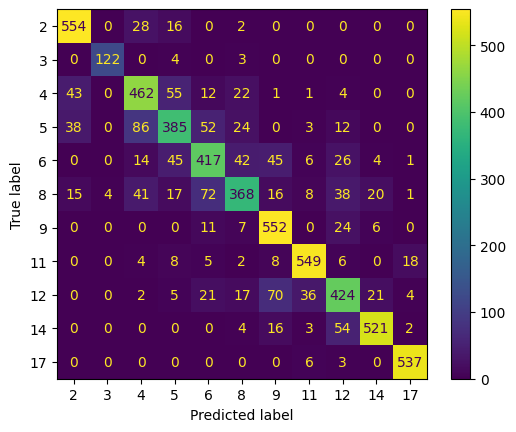

In [12]:
y_ae_dz_test_pred = ae_dz_classifier.evaluate()
ConfusionMatrixDisplay.from_estimator(ae_dz_classifier._classifier, ae_dz_classifier._X_test, ae_dz_classifier._y_test)

In [13]:
ae_dz_pred_roi_da = ae_dz_classifier.classify_roi(ae_embeddings_2018_da)
ae_dz_pred_roi_da

2025-09-19 13:42:57.927 | INFO     | classifiers.pixel_classifier:classify_roi:158 - Classifying entire ROI


<xarray.DataArray 'predicted_class' (y: 835, x: 774)> Size: 5MB
array([[14, 14, 14, ..., 14, 14, 14],
       [14, 14, 14, ..., 14, 14, 14],
       [14, 14, 14, ..., 14, 14, 14],
       ...,
       [14, 12, 12, ..., 14, 14, 14],
       [12, 12, 12, ..., 14, 14, 14],
       [14, 12, 12, ..., 14, 14, 14]], shape=(835, 774))
Coordinates:
  * y        (y) float64 7kB 5.784e+06 5.784e+06 ... 5.793e+06 5.793e+06
  * x        (x) float64 6kB 3.004e+05 3.004e+05 ... 3.081e+05 3.082e+05

#### GeoTessera

In [14]:
%time
gt_dz_classifier = PixelClassifier()
X, y, coords, labels_da = gt_dz_classifier.prepare_data(dz_lcz_da, gt_embeddings_2018_da, "LCZ_Filter", 2000)
gt_dz_classifier._classifier = rf_classifier
gt_dz_classifier.train()

2025-09-19 13:44:45.130 | INFO     | classifiers.pixel_classifier:prepare_data:103 - Preparing data for band LCZ_Filter
2025-09-19 13:44:45.215 | INFO     | classifiers.pixel_classifier:_sample_classes:26 - Sampling classes for band LCZ_Filter
2025-09-19 13:44:45.276 | INFO     | classifiers.pixel_classifier:_extract_embeddings:55 - Extracting embeddings for 20250 coordinates


CPU times: user 0 ns, sys: 12 μs, total: 12 μs
Wall time: 27.2 μs


2025-09-19 13:45:16.710 | INFO     | classifiers.pixel_classifier:train:141 - ✅ Model training complete.


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


2025-09-19 13:45:16.771 | INFO     | classifiers.pixel_classifier:evaluate:149 - 
--- 📊 Classification Report ---


              precision    recall  f1-score   support

           2       0.62      0.75      0.68       600
           3       0.84      0.33      0.47       129
           4       0.49      0.42      0.45       600
           5       0.42      0.40      0.41       600
           6       0.42      0.51      0.46       600
           8       0.53      0.40      0.46       600
           9       0.53      0.55      0.54       600
          11       0.62      0.73      0.67       600
          12       0.54      0.58      0.56       600
          14       0.87      0.77      0.82       600
          17       0.90      0.90      0.90       546

    accuracy                           0.59      6075
   macro avg       0.62      0.57      0.58      6075
weighted avg       0.60      0.59      0.59      6075



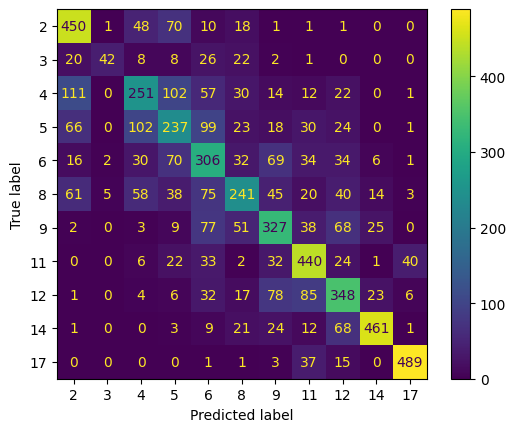

In [15]:
y_gt_dz_test_pred = gt_dz_classifier.evaluate()
ConfusionMatrixDisplay.from_estimator(gt_dz_classifier._classifier, gt_dz_classifier._X_test, gt_dz_classifier._y_test)

In [16]:
gt_dz_pred_roi_da = gt_dz_classifier.classify_roi(gt_embeddings_2018_da)
gt_dz_pred_roi_da

2025-09-19 13:45:17.362 | INFO     | classifiers.pixel_classifier:classify_roi:158 - Classifying entire ROI


<xarray.DataArray 'predicted_class' (y: 836, x: 775)> Size: 5MB
array([[12, 12, 12, ..., 14, 14, 14],
       [12, 12, 12, ..., 12, 14, 12],
       [12, 12, 12, ..., 12, 12, 12],
       ...,
       [14, 14, 14, ..., 14, 14, 14],
       [12, 14, 14, ..., 14, 14, 14],
       [14, 14, 14, ..., 14, 14, 14]], shape=(836, 775))
Coordinates:
  * y        (y) float64 7kB 5.793e+06 5.793e+06 ... 5.784e+06 5.784e+06
  * x        (x) float64 6kB 3.004e+05 3.004e+05 ... 3.082e+05 3.082e+05

### Predicting Geoclimate's LCZ classes (2024)
#### AlphaEarth
Unlike Demuzere's global data, Geoclimate is using the data available in OSM to classify patches of land in one of the 17 categories. This means that LCZs are only of the present day, and rely on the quality of OSM data, which as many folks know, it varies significantly from country to country (or by city, in this case). In this case, AlphaEarth outperforms GeoTessera as well, although both of them tend to make the same missclassifications (LCZ 4). Not really sure why, but the power of using Geoclimate as label is in the fact that it includes more information about built-up areas like roads or new buildings that are not present in Demuzere's dataset.

In [17]:
%time
ae_gc_classifier = PixelClassifier()
X, y, coords, labels_da = ae_gc_classifier.prepare_data(gc_lcz_da, ae_embeddings_2024_da, "LCZ_PRIMARY", 2000)
ae_gc_classifier._classifier = rf_classifier
ae_gc_classifier.train()

2025-09-19 13:57:19.761 | INFO     | classifiers.pixel_classifier:prepare_data:103 - Preparing data for band LCZ_PRIMARY
2025-09-19 13:57:19.862 | INFO     | classifiers.pixel_classifier:_sample_classes:26 - Sampling classes for band LCZ_PRIMARY
2025-09-19 13:57:19.924 | INFO     | classifiers.pixel_classifier:_extract_embeddings:55 - Extracting embeddings for 20110 coordinates


CPU times: user 1e+03 ns, sys: 12 μs, total: 13 μs
Wall time: 27.7 μs


2025-09-19 13:57:36.202 | INFO     | classifiers.pixel_classifier:train:141 - ✅ Model training complete.


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


2025-09-19 13:57:36.257 | INFO     | classifiers.pixel_classifier:evaluate:149 - 
--- 📊 Classification Report ---


              precision    recall  f1-score   support

           2       0.73      0.87      0.79       600
           4       0.91      0.97      0.94        33
           5       0.74      0.72      0.73       600
           6       0.49      0.41      0.45       600
           8       0.65      0.73      0.69       600
           9       0.50      0.52      0.51       600
          11       0.70      0.82      0.76       600
          12       0.73      0.76      0.74       600
          14       0.84      0.68      0.75       600
          15       0.58      0.46      0.51       600
          17       0.95      0.95      0.95       600

    accuracy                           0.69      6033
   macro avg       0.71      0.72      0.71      6033
weighted avg       0.69      0.69      0.69      6033



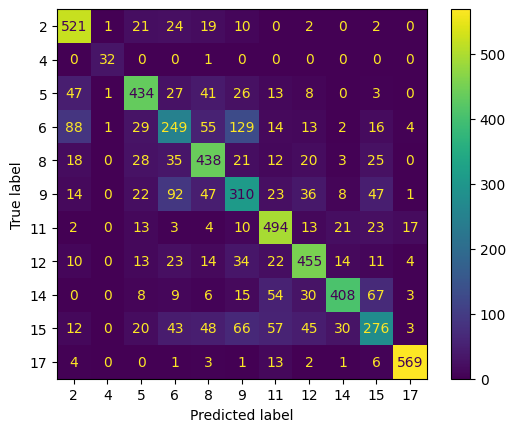

In [18]:
y_ae_gc_test_pred = ae_gc_classifier.evaluate()
ConfusionMatrixDisplay.from_estimator(ae_gc_classifier._classifier, ae_gc_classifier._X_test, ae_gc_classifier._y_test)

In [19]:
ae_gc_pred_roi_da = ae_gc_classifier.classify_roi(ae_embeddings_2024_da)
ae_gc_pred_roi_da

2025-09-19 13:57:36.841 | INFO     | classifiers.pixel_classifier:classify_roi:158 - Classifying entire ROI


<xarray.DataArray 'predicted_class' (y: 835, x: 774)> Size: 5MB
array([[14, 14, 12, ..., 14, 14, 14],
       [14, 12, 12, ..., 14, 14, 14],
       [12, 12, 12, ..., 14, 14, 14],
       ...,
       [14, 14, 15, ..., 14, 14, 14],
       [14, 14, 15, ..., 14, 14, 14],
       [14, 14, 14, ..., 14, 14, 14]], shape=(835, 774))
Coordinates:
  * y        (y) float64 7kB 5.784e+06 5.784e+06 ... 5.793e+06 5.793e+06
  * x        (x) float64 6kB 3.004e+05 3.004e+05 ... 3.081e+05 3.082e+05

#### GeoTessera

In [20]:
%time
gt_gc_classifier = PixelClassifier()
X, y, coords, labels_da = gt_gc_classifier.prepare_data(gc_lcz_da, gt_embeddings_2024_da, "LCZ_PRIMARY", 2000)
gt_gc_classifier._classifier = rf_classifier
gt_gc_classifier.train()

2025-09-19 13:59:10.557 | INFO     | classifiers.pixel_classifier:prepare_data:103 - Preparing data for band LCZ_PRIMARY
2025-09-19 13:59:10.638 | INFO     | classifiers.pixel_classifier:_sample_classes:26 - Sampling classes for band LCZ_PRIMARY
2025-09-19 13:59:10.715 | INFO     | classifiers.pixel_classifier:_extract_embeddings:55 - Extracting embeddings for 20100 coordinates


CPU times: user 1 μs, sys: 11 μs, total: 12 μs
Wall time: 23.8 μs


2025-09-19 13:59:48.400 | INFO     | classifiers.pixel_classifier:train:141 - ✅ Model training complete.


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


2025-09-19 13:59:48.445 | INFO     | classifiers.pixel_classifier:evaluate:149 - 
--- 📊 Classification Report ---


              precision    recall  f1-score   support

           2       0.49      0.61      0.55       600
           4       0.78      0.23      0.36        30
           5       0.44      0.27      0.33       600
           6       0.28      0.30      0.29       600
           8       0.49      0.50      0.49       600
           9       0.31      0.39      0.34       600
          11       0.49      0.64      0.55       600
          12       0.43      0.41      0.42       600
          14       0.69      0.66      0.68       600
          15       0.44      0.33      0.38       600
          17       0.87      0.76      0.81       600

    accuracy                           0.48      6030
   macro avg       0.52      0.46      0.47      6030
weighted avg       0.49      0.48      0.48      6030



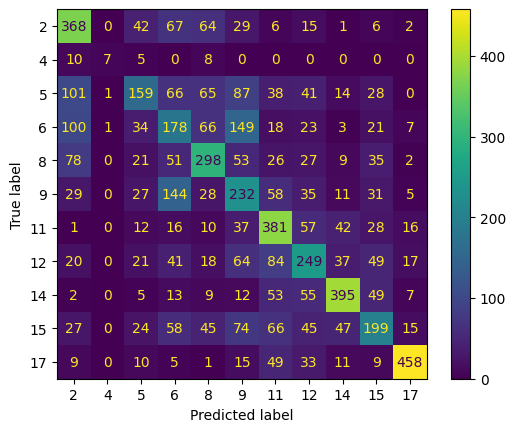

In [21]:
y_gt_gc_test_pred = gt_gc_classifier.evaluate()
ConfusionMatrixDisplay.from_estimator(gt_gc_classifier._classifier, gt_gc_classifier._X_test, gt_gc_classifier._y_test)

In [22]:
gt_gc_pred_roi_da = gt_gc_classifier.classify_roi(gt_embeddings_2024_da)
gt_gc_pred_roi_da

2025-09-19 13:59:48.981 | INFO     | classifiers.pixel_classifier:classify_roi:158 - Classifying entire ROI


<xarray.DataArray 'predicted_class' (y: 836, x: 775)> Size: 5MB
array([[14, 14, 14, ..., 14, 14, 14],
       [14, 14, 14, ..., 14, 14, 14],
       [14, 14, 14, ..., 14, 12, 12],
       ...,
       [14, 14, 14, ..., 14, 14, 14],
       [14, 14, 14, ..., 14, 14, 14],
       [14, 14, 14, ..., 14, 14, 14]], shape=(836, 775))
Coordinates:
  * y        (y) float64 7kB 5.793e+06 5.793e+06 ... 5.784e+06 5.784e+06
  * x        (x) float64 6kB 3.004e+05 3.004e+05 ... 3.082e+05 3.082e+05

## Conclusions
So, in general both AlphaEarth and GeoTessera are more than capable of classifying LCZs with Google's model performing slightly better. This is only a test using Cambridge as test study, so more experiments and fine-tuning are necessary. Clear improvements on the current state of LCZs are clear: Because of the resolution of the embeddings, they are picking up features at finer detail like roads or rivers that are not present in the labels; this means that although they are misclassified, they are actually correctly classified by the models (it's easier to see in the interactive map). You can see below a plot comparing the different embeddings and labels, and an additional interactive plot for an overlay on an OSM basemap. I'm more interested in how it performs in not so common places in Africa, Asia or Latin America, as the lack of data in OSM maps means that many attributes like building height are missing, which could mean that either AlphaEarth or GeoTessera can fill in the gap with the satellite data they were trained on.

Currently, I'm training a couple of models on Cambridge, London and Bogotá using a MLP classifier, as suggested by [Frank Feng](https://www.linkedin.com/in/zhengpeng-feng). To fine-tune the model, and more importantly, to track the results and performance I am implementing a Weights & Biases Sweep configuration so I can use the dashboard to make better informed decisions on where to go from there.

Detected original LCZ data. Using custom LCZ colormap. 🗺️


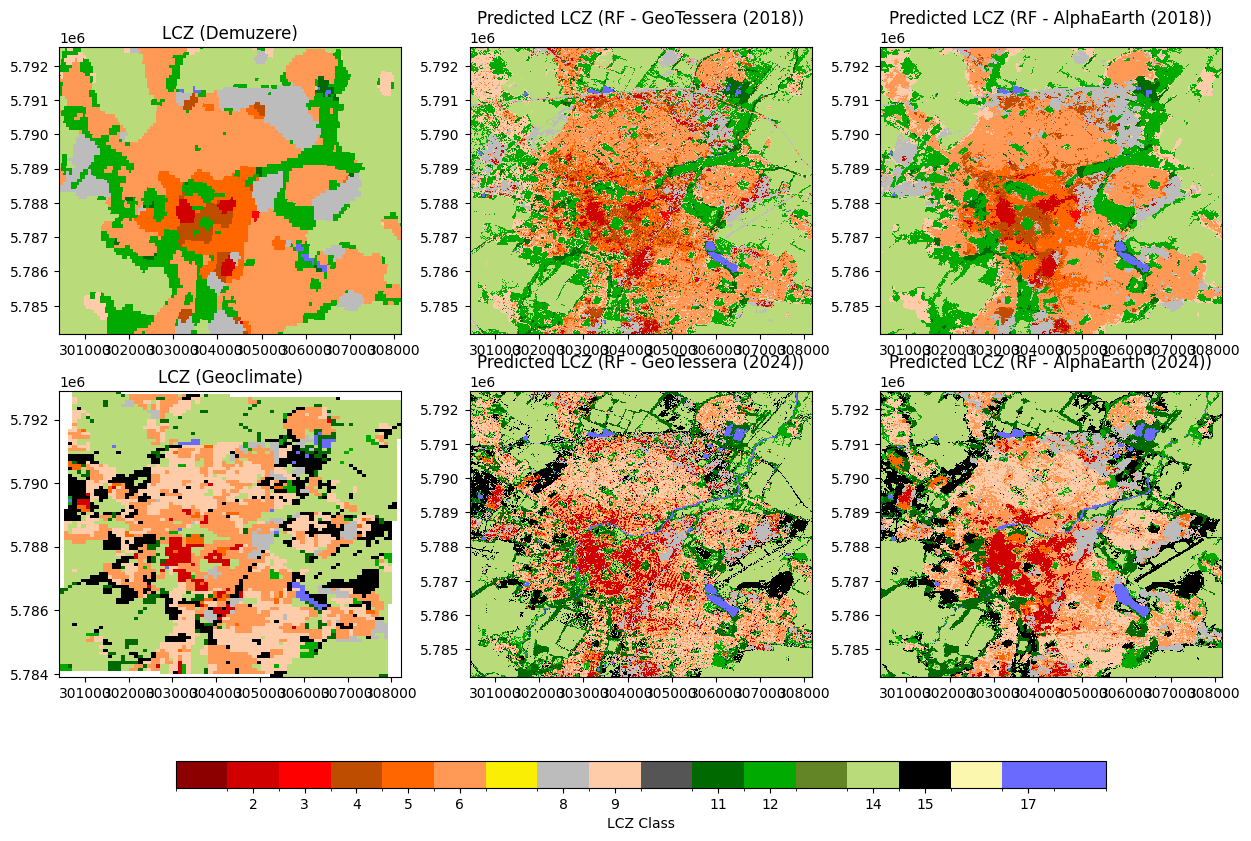

In [23]:
# 1. Get all unique values from the data.
# raw_unique_values = np.unique(np.concatenate([
#     labels_da.sel(band='LCZ_Filter').values.ravel(),
#     gt_pred_roi_da.values.ravel()
# ]))
raw_unique_values = np.unique(np.concatenate([
    dz_lcz_da.sel(band='LCZ_Filter').values.ravel(),
    gt_dz_pred_roi_da.values.ravel(),
    ae_dz_pred_roi_da.values.ravel(),
    gc_lcz_da.sel(band='LCZ_PRIMARY').values.ravel(),
    gt_gc_pred_roi_da.values.ravel(),
    ae_gc_pred_roi_da.values.ravel()
]))
# 2. Create a clean array for logic and ticks by filtering out NaN.
colorbar_ticks = raw_unique_values[~np.isnan(raw_unique_values)]

# 3. Handle the edge case where there is no valid data to plot.
if len(colorbar_ticks) == 0:
    print("⚠️ Warning: Data contains only NaN values. Cannot generate plot with colorbar.")
    # Draw blank plots as a fallback
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))
    axes[0].set_title("LCZ (Demuzere, 2022)\n(No data)")
    axes[1].set_title("Predicted LCZ (RF - GeoTessera)\n(No data)")
    plt.show()

else:
    # 4. Use the clean ticks to decide on the colormap.
    if colorbar_ticks.max() <= 2:
        print("Detected reclassified data. Using 'viridis' colormap. 🎨")
        num_classes = len(colorbar_ticks)
        cmap = plt.get_cmap('viridis', num_classes)
        boundaries = np.append(colorbar_ticks - 0.5, colorbar_ticks[-1] + 0.5)
        norm = mcolors.BoundaryNorm(boundaries, cmap.N)
    else:
        print("Detected original LCZ data. Using custom LCZ colormap. 🗺️")
        lcz_colors = [x['color'] for x in lcz_dict.values()]
        lcz_keys = list(lcz_dict.keys())
        cmap = ListedColormap(lcz_colors)
        boundaries = np.arange(min(lcz_keys) - 0.5, max(lcz_keys) + 1.6, 1)
        norm = mcolors.BoundaryNorm(boundaries, cmap.N+1)

    # 5. IMPORTANT: Tell the colormap how to render NaN values from the data.
    cmap.set_bad(color='white', alpha=0) # Make bad values (like NaN) fully transparent

    # --- Plotting ---
    fig, axes = plt.subplots(2, 3, figsize=(15, 12))

    im0 = dz_lcz_da.sel(band='LCZ_Filter').plot(ax=axes[0][0], add_colorbar=False, cmap=cmap, norm=norm)
    axes[0][0].set_title("LCZ (Demuzere)")

    im1 = gt_dz_pred_roi_da.plot(ax=axes[0][1], add_colorbar=False, cmap=cmap, norm=norm)
    axes[0][1].set_title("Predicted LCZ (RF - GeoTessera (2018))")
    im2 = ae_dz_pred_roi_da.plot(ax=axes[0][2], add_colorbar=False, cmap=cmap, norm=norm)
    axes[0][2].set_title("Predicted LCZ (RF - AlphaEarth (2018))")

    im3 = gc_lcz_da.sel(band='LCZ_PRIMARY').plot(ax=axes[1][0], add_colorbar=False, cmap=cmap, norm=norm)
    axes[1][0].set_title("LCZ (Geoclimate)")

    im4 = gt_gc_pred_roi_da.plot(ax=axes[1][1], add_colorbar=False, cmap=cmap, norm=norm)
    axes[1][1].set_title("Predicted LCZ (RF - GeoTessera (2024))")

    im5 = ae_gc_pred_roi_da.plot(ax=axes[1][2], add_colorbar=False, cmap=cmap, norm=norm)
    axes[1][2].set_title("Predicted LCZ (RF - AlphaEarth (2024))")

    # --- Layout and Colorbar ---
    axes[0][0].set_xlabel('')
    axes[0][0].set_ylabel('')
    axes[0][1].set_xlabel('')
    axes[0][1].set_ylabel('')
    axes[0][2].set_xlabel('')
    axes[0][2].set_ylabel('')
    axes[1][0].set_xlabel('')
    axes[1][0].set_ylabel('')
    axes[1][1].set_xlabel('')
    axes[1][1].set_ylabel('')
    axes[1][2].set_xlabel('')
    axes[1][2].set_ylabel('')
    fig.subplots_adjust(bottom=0.2, top=0.9)

    cbar = fig.colorbar(im1, ax=axes.ravel().tolist(), orientation='horizontal',
                        ticks=colorbar_ticks, shrink=0.8, aspect=35, pad=0.1)
    cbar.set_label('LCZ Class')

    plt.show()


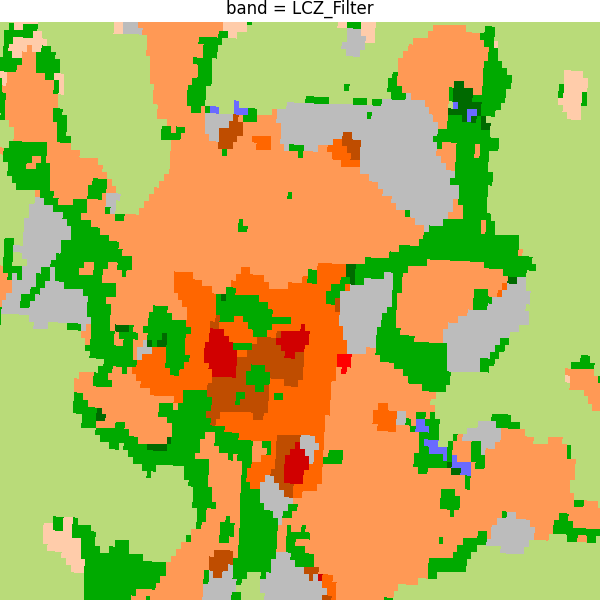
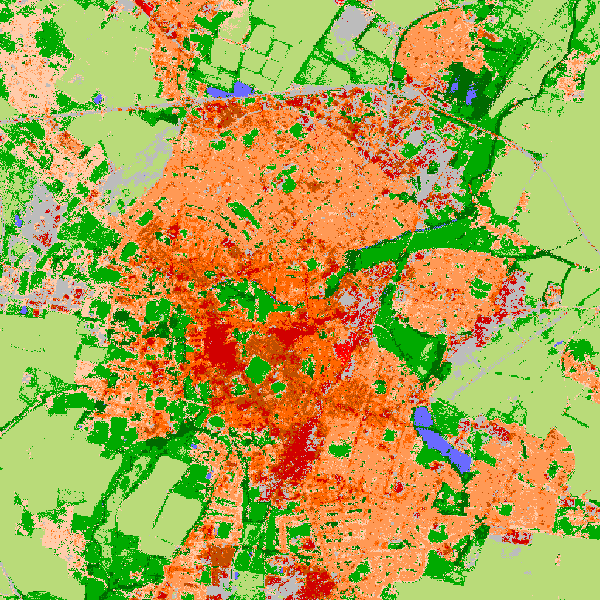
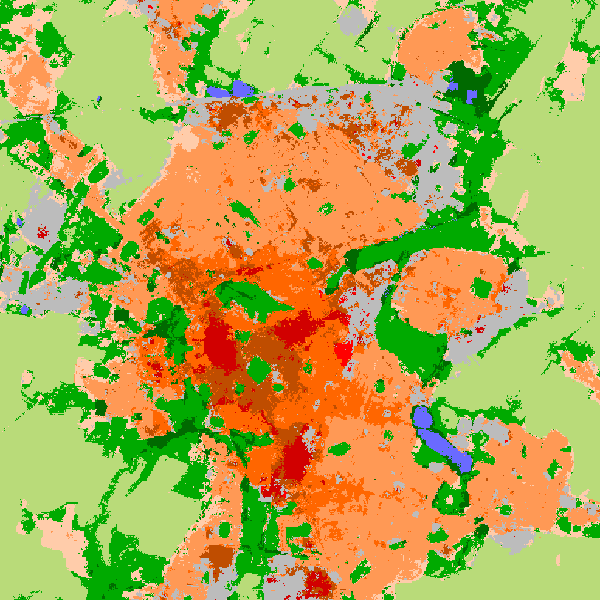
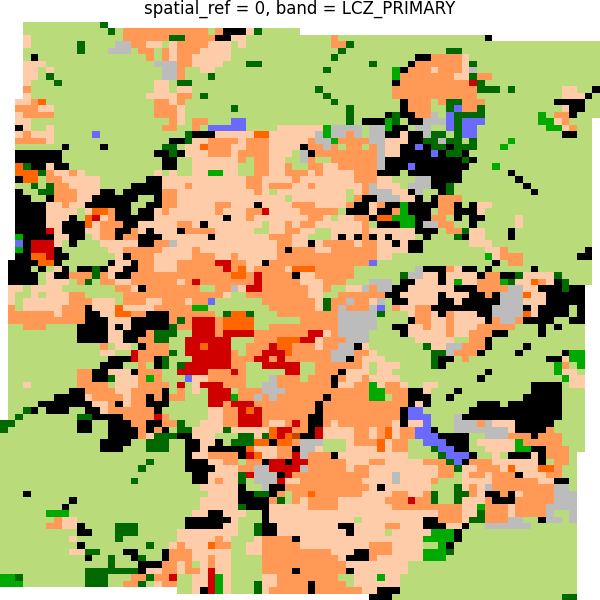
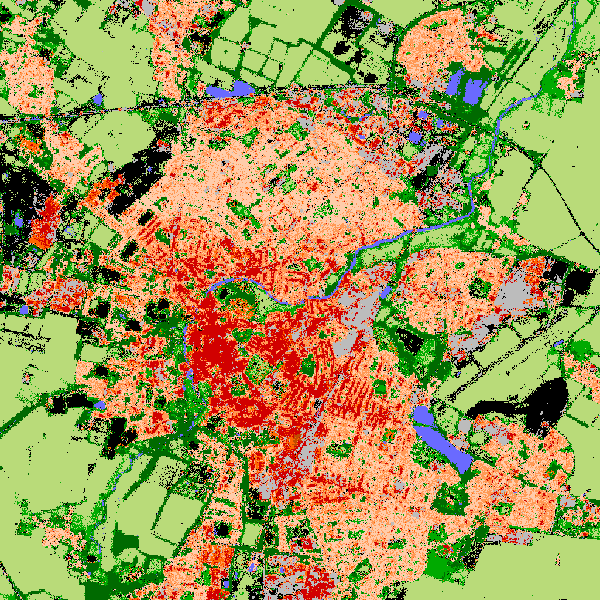
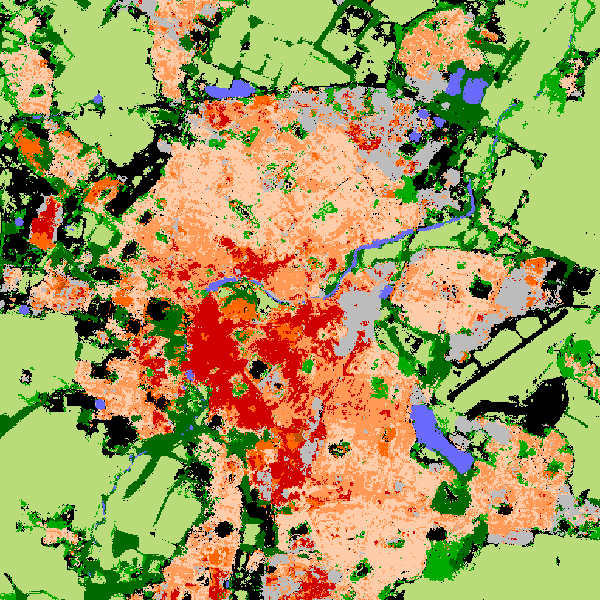

In [ ]:
import folium
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tempfile
import os
from folium.raster_layers import ImageOverlay

def add_overlay_to_map(fmap, da, ax_title, cmap, norm, bounds, opacity=0.6):
    """
    Plots a DataArray as an image overlay on a folium map.
    """
    # Plot to a temporary PNG file
    with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmpfile:
        fig, ax = plt.subplots(figsize=(6, 6))
        # Remove axis
        ax.axis('off')
        # Plot the data
        im = da.plot.imshow(ax=ax, cmap=cmap, norm=norm, add_colorbar=False)
        plt.tight_layout(pad=0)
        plt.savefig(tmpfile.name, bbox_inches='tight', pad_inches=0, transparent=True)
        plt.close(fig)
        img_path = tmpfile.name

    # Overlay on folium
    img_overlay = folium.raster_layers.ImageOverlay(
        name=ax_title,
        image=img_path,
        bounds=bounds,
        opacity=opacity,
        interactive=True,
        cross_origin=False,
        zindex=1,
    )
    img_overlay.add_to(fmap)

    # Remove the temp file after folium loads it
    os.remove(img_path)

# --- Get bounds for folium (in lat/lon) ---
# We'll use the city.bbox for the Cambridge example
# bbox = [min_lon, min_lat, max_lon, max_lat]
bbox = city_example.bbox  # [min_lon, min_lat, max_lon, max_lat]
bounds = [[bbox[1], bbox[0]], [bbox[3], bbox[2]]]  # [[south, west], [north, east]]

# Center for the map
center = [(bbox[1] + bbox[3]) / 2, (bbox[0] + bbox[2]) / 2]

# --- Prepare the six DataArrays to overlay ---
# Each should be 2D (y, x) and correspond to the correct region
# 1. Demuzere LCZ
dz_lcz_img = dz_lcz_da.sel(band='LCZ_Filter')
# 2. Predicted LCZ (RF - GeoTessera)
gt_dz_pred_img = gt_dz_pred_roi_da
# 3. Predicted LCZ (RF - AlphaEarth)
ae_dz_pred_img = ae_dz_pred_roi_da
# 4. Geoclimate LCZ
gc_lcz_img = gc_lcz_da.sel(band='LCZ_PRIMARY')
# 5. Predicted LCZ (RF - GeoTessera, Geoclimate)
gt_gc_pred_img = gt_gc_pred_roi_da
# 6. Predicted LCZ (RF - AlphaEarth, Geoclimate)
ae_gc_pred_img = ae_gc_pred_roi_da

# --- Create a folium map ---
fmap = folium.Map(location=center, zoom_start=13, tiles='cartodbpositron')

# --- Overlay each plot ---
add_overlay_to_map(fmap, dz_lcz_img, "LCZ (Demuzere)", cmap, norm, bounds)
add_overlay_to_map(fmap, gt_dz_pred_img, "Predicted LCZ (RF - GeoTessera, Demuzere)", cmap, norm, bounds)
add_overlay_to_map(fmap, ae_dz_pred_img, "Predicted LCZ (RF - AlphaEarth, Demuzere)", cmap, norm, bounds)
add_overlay_to_map(fmap, gc_lcz_img, "LCZ (Geoclimate)", cmap, norm, bounds)
add_overlay_to_map(fmap, gt_gc_pred_img, "Predicted LCZ (RF - GeoTessera, Geoclimate)", cmap, norm, bounds)
add_overlay_to_map(fmap, ae_gc_pred_img, "Predicted LCZ (RF - AlphaEarth, Geoclimate)", cmap, norm, bounds)

# Add layer control
folium.LayerControl().add_to(fmap)

# Display the map in the notebook
fmap


## Objectives
### Last Week
- ~~Fix the rasterisation bug from Geoclimate using the projection of the FM embeddings (AlphaEarth or TESSERA)~~
  - ~~Test the pixel classifier with the Geoclimate labels~~
- ~~Test other cities with the pixel classifier~~
- ~~Experiment with other models or try with cross validation to improve the performance~~

### This Week
- Start preparing the talk for PROPL25 and Imperial College talk
- Add customised plots to Wandb dashboard